In [1]:
import math
import os
import sys
sys.path.insert(0,'../src/')
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from database import SQLiteDatabase
from experiment import preliminary_setup
import query

In [2]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
register_matplotlib_converters()
DB_DIRECTORY = KWARGS['database_directory']
FIGURES_DIRECTORY = KWARGS['figure_directory']
DATABASE = SQLiteDatabase(os.path.join(DB_DIRECTORY,'rbc_reference_3.db'))

# Building-Level Scores

In [3]:
building_cost_data = DATABASE.query_table(query.get_building_cost_summary())

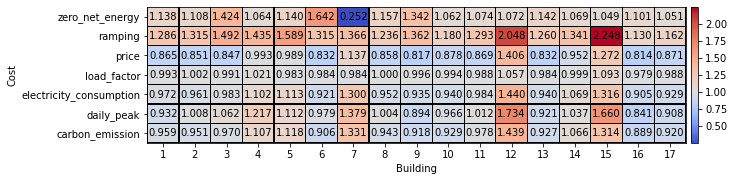

In [4]:
row_count = 1
column_count = 1
cmap = 'coolwarm'
fig, ax = plt.subplots(row_count, column_count, figsize=(10*column_count,2.5*row_count))
plot_data = building_cost_data.pivot(index='cost', columns='building_id', values='value')
vcenter = 1.0
x, y, z = plot_data.columns.astype(str), plot_data.index, plot_data.values
divnorm = colors.TwoSlopeNorm(vcenter=vcenter)
pcm = ax.pcolormesh(x,y,z,shading='nearest',cmap=cmap,norm=divnorm,edgecolors='black',linewidth=0.1)
_ = fig.colorbar(pcm,ax=ax,orientation='vertical',label='',fraction=0.025,pad=0.01)
ax.tick_params('x',which='both',rotation=0)
ax.set_xlabel('Building')
ax.set_ylabel('Cost')

for (i, j), z in np.ndenumerate(plot_data):
    color = 'black'
    ax.text(j,i,f'{z:0.3f}',ha='center',va='center',color=color)

plt.show()

# District-Level Scores

In [5]:
district_cost_data = DATABASE.query_table(query.get_district_cost_summary())

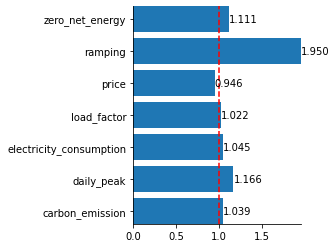

In [6]:
row_count = 1
column_count = 1
fig, ax = plt.subplots(row_count, column_count, figsize=(column_count*3, row_count*4))
plot_data = district_cost_data.copy()
x, y = plot_data['cost'], plot_data['value']
ax.barh(x, y)
ax.axvline(1.0, color='red', linestyle='--')

for s in ['right','top']:
    ax.spines[s].set_visible(False)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width(), p.get_y() + p.get_height()/2.0, f'{p.get_width():0.3f}', ha='left', va='center')
    
plt.show()

# Building-Level Average Load Profile

In [7]:
building_load_data = DATABASE.query_table(query.get_building_average_daily_profile())

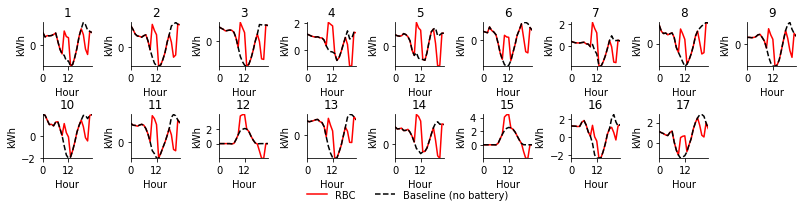

In [8]:
plot_data = building_load_data.copy()
column_count_limit = 9
building_id_count = len(plot_data['building_id'].unique())
row_count, column_count = math.ceil(building_id_count/column_count_limit), min(column_count_limit, building_id_count)
fig, _ = plt.subplots(row_count, column_count, figsize=(1.5*column_count, 1.25*row_count), gridspec_kw={'wspace':0.8, 'hspace':1.1})

for ax in fig.axes[int(row_count*column_count - 1):]:
    ax.set_visible(False)

for i, (ax, (b, b_data)) in enumerate(zip(fig.axes, plot_data.groupby(['building_id']))):
    x, y1, y2 = b_data['hour'], b_data['with_storage_value'], b_data['without_storage_value']
    ax.plot(x, y1, color='red', label='RBC')
    ax.plot(x, y2, color='black', linestyle='--', label='Baseline (no battery)')
    ax.set_title(b)
    ax.set_xlabel('Hour')
    ax.set_ylabel('kWh')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

    if i == 0:
        ax.legend(
            bbox_to_anchor=(0.5,0),
            loc='upper center', 
            bbox_transform=fig.transFigure,
            framealpha=0,
            ncol=2
        )
    else:
        ax.legend().set_visible(False)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

plt.show()

# District-Level Average Load Profile

In [9]:
district_load_data = DATABASE.query_table(query.get_district_average_daily_profile())

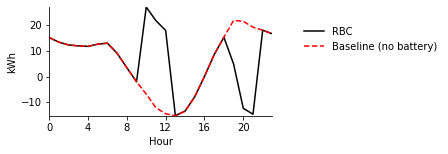

In [10]:
row_count = 1
column_count = 1 
fig, ax = plt.subplots(row_count, column_count, figsize=(4*column_count, 2*row_count))
plot_data = district_load_data.copy()
x, y1, y2 = plot_data['hour'], plot_data['with_storage_value'], plot_data['without_storage_value']
ax.plot(x, y1, color='black', label='RBC')
ax.plot(x, y2, color='red', linestyle='--', label='Baseline (no battery)')
ax.set_xlabel('Hour')
ax.set_ylabel('kWh')

for s in ['right','top']:
    ax.spines[s].set_visible(False)

ax.legend(
    bbox_to_anchor=(1.1,0.9),
    loc='upper left',
    framealpha=0,
    ncol=1
)
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.show()

# Save

In [11]:
# cost
building_cost_data['scope'] = 'building'
district_cost_data['scope']= 'district'
pd.concat([building_cost_data, district_cost_data], ignore_index=True, sort=False).to_csv(
    os.path.join(KWARGS['summary_directory'], 'rbc_reference_3_cost_summary.csv'), index=False
)

# load
building_load_data['scope'] = 'building'
district_load_data['scope']= 'district'
pd.concat([building_load_data, district_load_data], ignore_index=True, sort=False).to_csv(
    os.path.join(KWARGS['summary_directory'], 'rbc_reference_3_load_summary.csv'), index=False
)